# Light gradient boosting machine (LGBM) correction model training
Testing the training of a combined St Ebbes & High St LGBM correction model for NO2.

In [ ]:
# Python library imports
# ------------------------
import datetime as dt

%matplotlib inline

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
import pickle
from lightgbm import LGBMRegressor
import sys
import csv


sys.path.append( '/home/tonyb/Gdrive/MinicondaProjects/oxaria/qoax/' )
from ml_utils import load_no24_training, no2_feature_gen, rushhour

pd.plotting.register_matplotlib_converters()
# pd.set_option('display.max_colwidth', -1)

# File locations
# ----------------
data_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/'
rf_home = './'
#pngs = rf_home + 'pngs/'


## Define local functions
Declare some functions for use later & reduce code repetition.

## Load training data

In [ ]:
# Sensor data for colocated device at St Ebbes
# ----------------------------------------------
def load_no24_training(folder, ftr_list, combo_cols):
    df_list = []
    tuple_list = zip(ftr_list, combo_cols)
    for f, c in tuple_list:
        # read the feather files
        dftmp = (
            pd.read_feather(folder + f).set_index(["tag", "rec"]).sort_index()
        )
        # Convert all float64 cols to float32
        cols = dftmp.select_dtypes(np.float64).columns
        dftmp[cols] = dftmp[cols].astype(np.float32)
        # Combine the reference method conc column into 1 column
        dftmp["no2_ppb_combo"] = dftmp[c]
        # If its below 3 ug.m-3, its probably not, so set to nan
        dftmp["no2_ppb_combo"] = np.where(
            dftmp["no2_ppb_combo"] < 3.0, np.nan, dftmp["no2_ppb_combo"]
        )
        df_list.append(dftmp)
    df_out = pd.concat(df_list)
    return df_out


# Function to generate time lagged feature
# -----------------------------------------
def no2_feature_gen(df):
    # calc % change in all df cols over last 15 mins
    tmpdf1 = (
        df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
        .dropna(axis=1, how="all")
        .pct_change(periods=1)
    )
    tmpdf1.columns = ["pc15_" + name for name in list(tmpdf1.columns)]
    # and same over last 30 mins
    tmpdf2 = (
        df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
        .dropna(axis=1, how="all")
        .pct_change(periods=2)
    )
    tmpdf2.columns = ["pc30_" + name for name in list(tmpdf2.columns)]
    # merge % change stats back on to original df
    df = (
        df.merge(tmpdf1, left_index=True, right_index=True, how="left")
        .merge(tmpdf2, left_index=True, right_index=True, how="left")
        .set_index(["tag", "rec"])
    )
    return df


# Function to generate rush hour & temporal flag features
# --------------------------------------------------------
def rushhour(df):
    # calc integer flags for hour of observation
    df["hour"] = df.index.get_level_values(1).hour
    # and day of week
    df["day"] = df.index.get_level_values(1).dayofweek
    # and integer flag(s) for off-peak, morning & evening rush hours
    df.loc[
        (df.index.get_level_values(1).time >= dt.time(7, 30, 0))
        & (df.index.get_level_values(1).time >= dt.time(9, 30, 0))
        & (df.index.get_level_values(1).weekday < 5),
        "rushhour",
    ] = 1
    df.loc[
        (df.index.get_level_values(1).time >= dt.time(16, 0, 0))
        & (df.index.get_level_values(1).time >= dt.time(18, 0, 0))
        & (df.index.get_level_values(1).weekday < 5),
        "rushhour",
    ] = 2
    df["rushhour"] = np.where(df["rushhour"] >= 1, df["rushhour"], 0).astype(
        np.int32
    )
    return df


# Function to constrain get training features for a soecific date envelope
# --------------------------------------------------------------------------
def get_training_no2(dfs, env_start, env_stop):
    start = pd.to_datetime(env_start, yearfirst=True, utc=True)
    end = pd.to_datetime(env_stop, yearfirst=True, utc=True)

    print(
        "Getting training features for sensors between: "
        + str(start)
        + " and "
        + str(end)
        + "\n"
    )
    df_list = []

    for df in dfs:
        dftmp = (
            df.query("@start <= rec < @end")
            .reset_index()
            .set_index(["tag", "rec"])
        )
        df_list.append(dftmp)

    df_out = pd.concat(df_list).sort_index()
    df_out = df_out[~df_out.index.duplicated()]
    df_out = df_out.loc[
        :,
        [
            "val.no2.wev",
            "val.no2.aev",
            "val.no2.wec",
            "val.hmd",
            "val.tmp",
            "no2_ppb_combo",
            "no2_ppb_s",
            "no2_ppb_h",
            "val.no2.cnc_1_c1",
            "pc15_val.no2.wev",
            "pc15_val.no2.aev",
            "pc15_val.no2.wec",
            "pc15_val.hmd",
            "pc15_val.tmp",
            "pc15_val.no2.cnc_1_c1",
            "pc30_val.no2.wev",
            "pc30_val.no2.cnc",
            "pc30_val.no2.aev",
            "pc30_val.no2.wec",
            "pc30_val.hmd",
            "pc30_val.tmp",
            "pc30_val.no2.cnc_1_c1",
            "hour",
            "day",
            "rushhour",
        ],
    ]
    df_out = df_out.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    print(
        "Sensors in output :"
        + str(df_out.index.get_level_values(0).unique().tolist())
        + "\n"
    )
    return df_out


# Define a function to test model performance based on a range of max. no, of leaf node sizes
# ---------------------------------------------------------------------------------------------
# The following function estimates mean absolute error as a metric for model
# accuracy.The number of trees used is set to 100 (i.e. n_estimators). 500 trees have also been tested but
# without any imporvement in accuracy so 100 is used to reduce training times.
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    # Define the model
    model = RandomForestRegressor(
        max_leaf_nodes=max_leaf_nodes,
        random_state=7,
        n_jobs=-1,
        max_depth=max_depth,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=12000,
    )

    # Create a v simple pipeline that imputes missing input values before fitting the model to them
    # -----------------------------------------------------------------------------------------------
    my_pipeline = Pipeline(
        steps=[("preprocessor", SimpleImputer()), ("model", model)]
    )

    # Calculate a metric variable using the cross_val_score function
    # ----------------------------------------------------------------
    # The block below performs a cross validation excersise. For a given model configuration, it splits the
    # training set in 5 subsets and carries out a training sequence with the mean absolute error as a metric
    # of performance.
    # An avergae of those 5 MAE is then returned (see Figure below 'Validation' label).
    # This procedure ensures a robust training sequence as it removes the chance of
    # selecting a validation set that is very similar to the testing subset.
    #
    # Fit 5 random subsets of train_x & train_y to the pipeline RFR model & calc mean absolute error
    # multiply by -1 since sklearn calculates *negative* MAE
    metric = -1 * cross_val_score(
        my_pipeline, train_X, train_y, cv=5, scoring="neg_mean_absolute_error"
    )

    # Train the model
    my_pipeline.fit(train_X, train_y)

    # Predict dependent variable using validation & training subsets of independent variables
    preds_val = my_pipeline.predict(val_X)
    preds_tr = my_pipeline.predict(train_X)

    # MAE calculation for training and validation data
    mae_ver = mean_absolute_error(val_y, preds_val)
    mae_tr = mean_absolute_error(train_y, preds_tr)

    # Bring it all together in outputs
    return (mae_ver, mae_tr, metric.mean())


# Function to plot a storyboard of model validation
# --------------------------------------------------
def plot_training_story_board(df, title, save_it, xylim, *args):
    sns.set_style("white", {"axes.grid": False})
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.3))
    fig.suptitle(
        title, y=1.1, fontsize=14,
    )
    plt.rcParams["ytick.labelsize"] = "12"
    plt.rcParams["xtick.labelsize"] = "12"
    plt.rcParams["figure.titlesize"] = "12"

    # xlim = xylim[0], xylim[1])
    axes[0].set_xlim(xylim[0], xylim[1])

    # Get regression stats - sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        train_df["val.no2.cnc_1_c1"], train_df["no2_ppb_combo"]
    )
    # Plot it
    sns.regplot(
        x=train_df["no2_ppb_combo"],
        y=train_df["val.no2.cnc_1_c1"],
        color="tab:blue",
        line_kws={
            "label": "y = {0:.3f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[0],
        truncate=False,
    )
    axes[0].set(
        xlabel="AURN NO2 (ppb)",
        ylabel="Sensor NO2 (ppb)",
        title="Uncorrected sensor vs Reference method\n (all observations)",
        xlim=(-10, 180),
        ylim=(-10, 180),
        xticks=(np.arange(0, 185, 25)),
        yticks=(np.arange(0, 185, 25)),
    )

    one = [0, 180]
    sns.regplot(
        x=one,
        y=one,
        color="k",
        line_kws={"label": "1:1", "ls": ":", "lw": 1},
        scatter_kws={"s": 0},
        ax=axes[0],
        ci=None,
    )

    axes[1].set_xlim(xlim)

    # Recalc regression stats - uncorrected validation subset sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        val_y, val_X["val.no2.cnc_1_c1"]
    )
    # Plot it
    sns.regplot(
        x=val_y,
        y=val_X["val.no2.cnc_1_c1"],
        color="tab:orange",
        line_kws={
            "label": "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[1],
        truncate=False,
    )
    axes[1].set(
        xlabel="Reference method NO2 (ppb)",
        ylabel="Sensor NO2 (ppb)",
        title="Uncorrected sensor vs Reference method\n (validation subset)",
        xlim=(-10, 180),
        ylim=(-10, 180),
        xticks=(np.arange(0, 185, 25)),
        yticks=(np.arange(0, 185, 25)),
    )

    one = [0, 180]
    sns.regplot(
        x=one,
        y=one,
        color="k",
        line_kws={"label": "1:1", "ls": ":", "lw": 1},
        scatter_kws={"s": 0},
        ax=axes[1],
        ci=None,
    )

    axes[2].set_xlim(xlim)

    # # Recalc regression stats - corrected validation subset sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        val_y, model_prediction
    )
    sns.regplot(
        x=val_y,
        y=model_prediction,
        color="tab:green",
        line_kws={
            "label": "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[2],
        truncate=False,
    )
    axes[2].set(
        xlabel="Reference method NO2 (ppb)",
        ylabel="Corrected Sensor NO2 (ppb)",
        title="Corrected sensor vs Reference method\n (validation subset)",
        xlim=(-2, 50),
        ylim=(-2, 50),
        xticks=(np.arange(0, 55, 10)),
        yticks=(np.arange(0, 55, 10)),
    )

    one = [0, 50]
    sns.regplot(
        x=one,
        y=one,
        color="k",
        line_kws={"label": "1:1", "ls": ":", "lw": 1},
        scatter_kws={"s": 0},
        ax=axes[2],
        ci=None,
    )

    axes[0].legend(loc="upper center", fontsize=11)
    axes[1].legend(loc="upper center", fontsize=11)
    axes[2].legend(loc="upper center", fontsize=11)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.subplots_adjust(wspace=0.3)

    if save_it == True:
        plt.savefig(
            f"training_storyboard_no2_mln{str(model.max_leaf_nodes)}_e{str(model.n_estimators)}_{png_descriptor}.png",
            dpi=300,
        )
    plt.show()
    return


# Function for plotting the verification results - split
# -------------------------------------------------------
def timeseries_plot_split(
    val_X, val_y, title, save_it, lower_pane_lims, upper_pane_lims, **kwargs
):
    # Model prediction
    # Set training & target variables
    #     val_X = df.drop(
    #         columns=['no2_ppb_s', 'pm25_ugg_s', 'no2_ppb_h', 'no2_ppb_combo']
    #     )
    #     val_y = df['no2_ppb_combo']

    model_prediction = model.predict(val_X)
    sns.set_style("white", {"axes.grid": False})
    myFmt = mdates.DateFormatter("%b")
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    sns.lineplot(
        x=val_y.index.get_level_values(1),
        y=val_y.values,
        label="Reference method target",
        color="k",
        lw=4,
        zorder=2,
        ax=ax,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=model_prediction,
        label="Corrected sensor",
        color="tab:green",
        zorder=3,
        ax=ax,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=val_X["val.no2.cnc_1_c1"].values,
        label="Uncorrected sensor",
        color="tab:red",
        zorder=1,
        ax=ax,
    )
    sns.lineplot(
        x=val_y.index.get_level_values(1),
        y=val_y.values,
        color="k",
        lw=4,
        zorder=2,
        ax=ax2,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=model_prediction,
        color="tab:green",
        zorder=3,
        ax=ax2,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=val_X["val.no2.cnc_1_c1"].values,
        color="tab:red",
        zorder=1,
        ax=ax2,
    )
    # zoom-in / limit the view to different portions of the data
    ax.set_ylim(
        upper_pane_lims[0], upper_pane_lims[1]
    )  # (100, 300)  # outliers only
    ax2.set_ylim(
        lower_pane_lims[0], lower_pane_lims[1]
    )  # (-5, 30)  # most of the data

    # hide the spines between ax and ax2
    ax.spines["bottom"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax.xaxis.set_ticks_position("none")
    ax2.yaxis.set_label_coords(-0.05, 1.1)
    ax.yaxis.label.set_visible(False)

    d = 0.007  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color="k", clip_on=False, lw=0.75)
    ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    ax2.xaxis.set_major_formatter(myFmt)
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # What's cool about this is that now if we vary the distance between
    # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
    # the diagonal lines will move accordingly, and stay right at the tips
    # of the spines they are 'breaking'

    f.subplots_adjust(hspace=0.05)

    plt.ylabel("NO2 (ppb)", fontsize=11)
    ax.legend(loc="upper left", fontsize=11)
    ax.set_title(
        str(title), fontsize=14,
    )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    if save_it is True:
        plt.savefig(
            f"split_validation_ts_no2_mln{model.max_leaf_nodes}_e{model.n_estimators}_str({png_descriptor}).png",
            dpi=300,
        )
    plt.show()


# Function for plotting the verification results - split
# -------------------------------------------------------
def timeseries_plot(val_X, val_y, title, save_it, **kwargs):
    # Model prediction
    # Set training & target variables
    #     val_X = df.drop(
    #         columns=['no2_ppb_s', 'pm25_ugg_s', 'no2_ppb_h', 'no2_ppb_combo']
    #     )
    #     val_y = df['no2_ppb_combo']

    model_prediction = model.predict(val_X)
    sns.set_style("white", {"axes.grid": False})
    myFmt = mdates.DateFormatter("%b")
    f, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 6))
    sns.lineplot(
        x=val_y.index.get_level_values(1),
        y=val_y.values,
        label="Reference method target",
        color="k",
        lw=4,
        zorder=2,
        ax=ax,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=model_prediction,
        label="Corrected sensor",
        color="tab:green",
        zorder=3,
        ax=ax,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=val_X["val.no2.cnc_1_c1"].values,
        label="Uncorrected sensor",
        color="tab:red",
        zorder=1,
        ax=ax,
    )

    f.subplots_adjust(hspace=0.05)

    plt.ylabel("NO2 (ppb)", fontsize=11)
    ax.legend(loc="upper left", fontsize=11)
    ax.set_title(
        str(title), fontsize=14,
    )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    if save_it is True:
        plt.savefig(
            f"validation_ts_no2_mln{model.max_leaf_nodes}_e{model.n_estimators}_str({png_descriptor}).png",
            dpi=300,
        )
    plt.show()


In [ ]:
# Load training data
# --------------------
# st ebbes
sebbes_files = [
    "jun_to_sept_2021/sebbes_train_s15+2021_oct_update_transients.ftr"
]
sebbes_columns = ["no2_ppb_s", "no2_ppb_s", "no2_ppb_s"]

sebbes_train_s15 = load_no24_training(data_home, sebbes_files, sebbes_columns)

# high st
highs_files = [
    "jun_to_sept_2021/highs_train_s15+2021_oct_update_transients.ftr"
]
highs_columns = ["no2_ppb_h", "no2_ppb_h", "no2_ppb_h"]

highs_train_s15 = load_no24_training(data_home, highs_files, highs_columns)

highs_train_s15 = highs_train_s15[~highs_train_s15.index.duplicated()]
sebbes_train_s15 = sebbes_train_s15[~sebbes_train_s15.index.duplicated()]


## Do some feature engineering

In [ ]:
# Apply feature generation functions to St Ebbes training
# ---------------------------------------------------------
tmp_list = []
for tag, dat in sebbes_train_s15.reset_index().groupby("tag"):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
sebbes_train_s15_1 = pd.concat(tmp_list)

# Apply feature generation functions to High St training
# ---------------------------------------------------------
tmp_list = []
for tag, dat in highs_train_s15.reset_index().groupby("tag"):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
highs_train_s15_1 = pd.concat(tmp_list)


## Subset to constrain to training features
Select only interesting features & subset / constrain the training sample population to specific time envelope.

In [ ]:
# Create the training dataset
# -----------------------------
sebbes_train_df = get_training_no2(
    [sebbes_train_s15_1], "2020-06-01", "2021-09-01"
)
highs_train_df = get_training_no2(
    [highs_train_s15_1], "2020-11-01", "2021-09-01"
)
train_df = pd.concat([sebbes_train_df, highs_train_df])


## Organise training data

In [ ]:
# Define the training dataset. In this 1st cut using the full St Ebbes timeseries Jun-Nov
# ------------------------------------------------------------------------------------------

# Set training & target variables
X = train_df.drop(
    columns=["no2_ppb_s", "no2_ppb_h", "no2_ppb_combo"]
)  # remove target variable (i.e. no2) from training set.

y = train_df["no2_ppb_combo"]  # define target variable (i.e. no2).

# Split into training & validation (test) datasets for both dependent & independent variables
train_X, val_X, train_y, val_y = train_test_split(
    X, y, random_state=7, test_size=0.2
)


##  Prepare training data

In [ ]:
# Prep the data inputs
#----------------------
# Impute missing stuff
imp = SimpleImputer(strategy="most_frequent")
train_X_imp = pd.DataFrame(imp.fit_transform(train_X))
train_X_imp.columns = train_X.columns
train_X_imp.index = train_X.index

# Normalise training data
norm = Normalizer()
train_X_imp_norm = pd.DataFrame(norm.fit_transform(train_X_imp))
train_X_imp_norm.columns = train_X_imp.columns
train_X_imp_norm.index = train_X_imp.index

# Normalise validation data
norm = Normalizer()

val_X_norm = pd.DataFrame(norm.fit_transform(val_X))
val_X_norm.columns = val_X.columns
val_X_norm.index = val_X.index
# val_X_norm.info()


## This code block used to identify the model parameters

In [ ]:
# model = LGBMRegressor()

# param_grid = {
#     "objective": ["regression"],
#     "linear_tree": [False],
#     "boosting_type": ["gbdt"],
#     "learning_rate": [0.1],
#     "max_depth": [5, 10, 20, 30, 40],
#     "num_leaves": [5, 10, 15, 20, 25],
#     "n_estimators": [7500, 8000, 8500, 9000, 9500, 10000],
# }

# searchgrid = GridSearchCV(model, param_grid, n_jobs=15, cv=5)
# searchgrid.fit(train_X_imp_norm, train_y)
# print("Best parameter (CV score=%0.3f):" % searchgrid.best_score_)
# print(searchgrid.best_params_)


In [ ]:
# Redefine the model using best tree size & number of estimators (l2)
# --------------------------------------------------
sns.set_style("white", {"axes.grid": True})

params = {
    "objective": "regression",
    "linear_tree": False,
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "max_depth": 20,
    "num_leaves": 20,
    "n_estimators": 10000,
}

one = [0, 20, 40, 50]
upper = [i * 1.25 for i in one]
lower = [i * 0.75 for i in one]

model = LGBMRegressor(**params)
model.fit(train_X_imp_norm, train_y)
model_prediction = model.predict(val_X_norm)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.regplot(x=val_y, y=model_prediction)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, model_prediction
)
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_y, val_X["val.no2.cnc_1_c1"])

fig = plt.figure(1, figsize=(6, 6))
#fig.add_subplot(111)
ax = sns.regplot(
    x=val_y,
    y=model_prediction,
    color="tab:green",
    line_kws={
        "label": "y={0:.2f}x+{1:.2f},\nR-sqd={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}".format(
            slope, intercept, r_value ** 2, mae_veri, mae_orig
        ),
        "color": "k",
    },
)
ax.set_xlim(-5, 140)
ax.set_ylim(-5, 140)
plt.legend(fontsize=11)
plt.ylabel("Corrected unseen sensor data (ppb)", fontsize=11)
plt.xlabel("NO2 reference (ppb)", fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()


## Export data to CSV for the CEN expanded uncertainty calculations

In [ ]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
# ----------------------------------------------------------------------------
outfile = list(
    zip(
        val_y.index.get_level_values(0),
        val_y.index.get_level_values(1).strftime('%m/%d/%Y %H:%M:%S'),
        val_y.values,
        model_prediction,
    )
)

with open(
    "values_for_cen_calc_LGBM_model_no2_jun_aug_val_c2_SH_xt_14jun_norm.csv",
    "w",
) as out:
    csv_out = csv.writer(out)
    csv_out.writerow(
        ["tag", "datetime", "no2_ppb_combo", "val_no2_cnc_1_c2_SH_xt_norm"]
    )
    csv_out.writerows(outfile)

# Print the  MAE stats for model configured with extra uniform backround time slots
# -----------------------------------------------------------------------------------
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_y, val_X["val.no2.cnc_1_c1"])

print(
    "MAE in uncorrected verifiction data for Jun-20 to Sep-21 with uniform baseline: "
    + str(mae_orig)
)
print(
    "MAE in corrected verifiction data for Jun-20 to Sep-21 with uniform baseline: "
    + str(mae_veri)
)
print("% 0.1f" % mae_orig, "% 0.1f" % mae_veri)


## Save the model to disk

In [ ]:
# Save the model to disk
# ------------------------
filename = "LGBM_model_no2_jun_aug_val_c2_SH_xt_14jun_norm.sav"
pickle.dump(model, open(filename, "wb"))


## Load the model from disk

In [ ]:
# Read the saved model to avoid all the working above
# -----------------------------------------------------
model = pickle.load(
    open("LGBM_model_no2_jun_aug_val_c2_SH_xt_14jun_norm.sav", "rb")
)


## Load data for correction (deploying to full dataset)

In [ ]:
# Load baseline adjusted gases data
# -----------------------------------
gases = pd.read_feather(
    data_home
    + "jun_to_sept_2021/oxaria_gases_536_stable15_bl_adjusted_ratified_2021_oct_update_transients.ftr"
).set_index(["tag", "rec"])
#                                 q12021/oxaria_gases_536_stable15_bl_adjusted_ratified+2021_sept_update_transients_v2.ftr
gases.rename(
    columns={"val.sht.tmp": "val.sht.tmp_g", "val.sht.hmd": "val.sht.hmd_g"},
    inplace=True,
)

auto_merged = pd.read_feather(
    data_home + "jun_to_sept_2021/auto_merged_ratified+2021_oct_update.ftr"
)
gases.info()


## Feature engineering & prep on full dataset

In [ ]:
# Function to generate the remaining feature required by the correction model
# -----------------------------------------------------------------------------
def no2_feature_gen(df):
    # calc % change in all df cols over last 15 mins
    tmpdf1 = (
        df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
        .dropna(axis=1, how="all")
        .pct_change(periods=1)
    )
    tmpdf1.columns = ["pc15_" + name for name in list(tmpdf1.columns)]
    # and same over last 30 mins
    tmpdf2 = (
        df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
        .dropna(axis=1, how="all")
        .pct_change(periods=2)
    )
    tmpdf2.columns = ["pc30_" + name for name in list(tmpdf2.columns)]
    # merge % change stats back on to original df
    df = (
        df.merge(tmpdf1, left_index=True, right_index=True, how="left")
        .merge(tmpdf2, left_index=True, right_index=True, how="left")
        .set_index(["tag", "rec"])
    )
    return df


def rushhour(df):
    # calc integer flags for hour of observation
    df["hour"] = df.index.get_level_values(1).hour
    # and day of week
    df["day"] = df.index.get_level_values(1).dayofweek
    # and integer flag(s) for off-peak, morning & evening rush hours
    df.loc[
        (df.index.get_level_values(1).time >= dt.time(7, 30, 0))
        & (df.index.get_level_values(1).time >= dt.time(9, 30, 0))
        & (df.index.get_level_values(1).weekday < 5),
        "rushhour",
    ] = 1
    df.loc[
        (df.index.get_level_values(1).time >= dt.time(16, 0, 0))
        & (df.index.get_level_values(1).time >= dt.time(18, 0, 0))
        & (df.index.get_level_values(1).weekday < 5),
        "rushhour",
    ] = 2
    df["rushhour"] = np.where(df["rushhour"] >= 1, df["rushhour"], 0).astype(
        np.int32
    )
    return df

# Add the features needed by the LGDM model
# ---------------------------------------
tmp_list = []
for tag, dat in gases.reset_index().groupby("tag"):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
gases1 = pd.concat(tmp_list)

# Subset the df to include only cols needed by model
# ----------------------------------------------------
gases2 = gases1.loc[
    :,
    [
        "val.no2.wev",
        "val.no2.aev",
        "val.no2.wec",
        "val.sht.hmd_g",
        "val.sht.tmp_g",
        "val.no2.cnc_1_c1",
        "pc15_val.no2.wev",
        "pc15_val.no2.aev",
        "pc15_val.no2.wec",
        "pc15_val.sht.hmd_g",
        "pc15_val.sht.tmp_g",
        "pc15_val.no2.cnc_1_c1",
        "pc30_val.no2.wev",
        "pc30_val.no2.cnc",
        "pc30_val.no2.aev",
        "pc30_val.no2.wec",
        "pc30_val.sht.hmd_g",
        "pc30_val.sht.tmp_g",
        "pc30_val.no2.cnc_1_c1",
        "hour",
        "day",
        "rushhour",
    ],
]

# Drop weirdness in some columns
gases2 = gases2.replace([np.inf, -np.inf], np.nan).dropna(axis=0).sort_index()


# Normalise the data inputs, load the LGBM model & run
# -----------------------------------------------------
gases2_norm = pd.DataFrame(norm.fit_transform(gases2))
gases2_norm.columns = gases2.columns
gases2_norm.index = gases2.index

# calc predicted vals & merge with input
corrected_no2_vals = pd.concat(
    [
        gases2.reset_index(),
        pd.DataFrame(
            model.predict(gases2_norm), columns=["val.no2.cnc_1_lgbm_norm"]
        ),
    ],
    axis=1,
    join="outer",
).set_index(["tag", "rec"])

# Merge with subset
gases = gases.merge(
    corrected_no2_vals["val.no2.cnc_1_lgbm_norm"],
    on=["tag", "rec"],
    how="left",
)

## Correct for non-unity slope & non-zero intercept terms

In [ ]:
# Correct for non-unity regressions terms & save
# -----------------------------------------------
gases["val.no2.cnc_1_lgbm_norm_cor"] = (gases["val.no2.cnc_1_lgbm_norm"] - 3.151) / 0.762

# Get rid of the typos
# ----------------------
mydict = {"Jahlul": "Ahlul", "Road": "Rd", "Street": "St", "Mosque": "Centre"}
gases["name"].replace(mydict, inplace=True, regex=True)
gases.info()


## Show corrected snsnor obsevations for each sensor vs reference measurements

In [ ]:
plt.style.use("default")
myFmt = mdates.DateFormatter("%b")
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2021, 11, 1)

fig, axes = plt.subplots(
    nrows=6, ncols=3, sharex=False, sharey=True, figsize=(17, 21)
)
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    "15-minute corrected sensor & reference method observations by sensor location, 2020-21.",
    y=0.91,
)
for idx, dat in gases.groupby("name"):
    ax = axes_list.pop(0)
    dat.sort_index(inplace=True)
    dat.reset_index(inplace=True)
    t_name = dat["name"].unique()
    t_tag = dat["tag"].unique()
    title_txt = str(t_name) + " " + str(t_tag)
    dat.plot(
        x="rec",
        y="val.no2.cnc_1_lgbm_norm",
        c="tab:pink",
        lw=0.7,
        marker="",
        ms=1,
        ls="-",
        label="LGBM sensor correction",
        ax=ax,
        legend=True,
        zorder=2,
        x_compat=True,
    )
    dat.plot(
        x="rec",
        y="val.no2.cnc_1_lgbm_norm_cor",
        c="red",
        lw=0.7,
        marker="",
        ms=1,
        ls="-",
        label="LGBM, intercept & slope sensor correction",
        ax=ax,
        legend=True,
        zorder=1,
        x_compat=True,
    )
    # dat.plot(x='rec', y='val.no2.cnc_1', c='tab:blue', lw=0.7, marker='', ms=1, ls='-',
    #          label='UnCorrected sensor', ax=ax, legend=True, zorder=1, x_compat=True)
    auto_merged.reset_index().query('sitecode_s == "OX8"').plot(
        x="rec",
        y="no2_ppb_s",
        c="tab:blue",
        lw=0.7,
        marker="",
        ms=0.1,
        ls="-",
        label="Reference method (urban background)",
        ax=ax,
        legend=True,
        zorder=3,
        alpha=0.6,
    )
    auto_merged.reset_index().query('sitecode_h == "OX6"').plot(
        x="rec",
        y="no2_ppb_h",
        c="tab:green",
        lw=0.7,
        marker="",
        ms=0.1,
        ls="-",
        label="Reference method (urban traffic)",
        ax=ax,
        legend=True,
        zorder=1,
        alpha=0.5,
    )
    ax.set_title(title_txt, fontsize=9)
    # ax.set_xticks(x_ticks)
    # ax.set_xticklabels(x_labels)
    ax.tick_params(axis="x", which="major", labelrotation=0, labelsize=7)
    ax.xaxis.set_major_formatter(myFmt)
    ax.tick_params(axis="y", labelsize=9)
    ax.tick_params(axis="x", which="minor", length=0.2)
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(-15, 140)
    ax.set_ylabel("[NO2] (ppb)", fontsize=8)
    ax.set_xlabel("")

    plt.subplots_adjust(wspace=0.04, hspace=0.3)

    leg = ax.legend(
        frameon=True, framealpha=0.2, loc="upper left", ncol=1, fontsize=7
    )

    for line in leg.get_lines():
        line.set_linewidth(2.0)

fig.delaxes(axes_list[-1])

# plt.savefig(pngs+'oxaria0_pm10_15m_fullycorrected_sensor_ts202021.png')
plt.show()

# for ax in axes_list:
#     ax.remove()


## Compensate for 'over-correction' using LGBM


In [ ]:
# Set corrected obs to St Ebbes baseline where its below St Ebbes baseline
#--------------------------------------------------------------------------
gases["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
     gases["val.no2.cnc_1_lgbm_norm_cor"] < gases["no2_ppb_s_bl"],
     gases["no2_ppb_s_bl"],
     gases["val.no2.cnc_1_lgbm_norm_cor"],
)

# Set corrected obs to nominal low conc where its still low
#-----------------------------------------------------------
gases["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
    gases["val.no2.cnc_1_lgbm_norm_cor_blc"] < 0.5,
    0.5,
    gases["val.no2.cnc_1_lgbm_norm_cor_blc"],
)

display(gases.groupby("name")[["val.no2.cnc_1_lgbm_norm_cor"]].describe(),
gases.groupby("name")[["val.no2.cnc_1_lgbm_norm_cor_blc"]].describe())



## Calculate feature/parameter importance

In [ ]:
# Permutation importance is a method for determining how important a parameter is by sequentially
# shuffling model parameters and measuring the effect on model accuracy (MAE in this case)

# perform permutation importance
results = permutation_importance(
    model, train_X_imp_norm, train_y, scoring="neg_mean_squared_error"
)

# get importance
importance = results.importances_mean
importance = pd.DataFrame(importance, index=train_X.columns, columns=["MSE"])
importance = importance.sort_values(by="MSE", ascending=False)

sns.set_style("white", {"axes.grid": False})

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
plt.bar(importance.index, importance.MSE)
plt.ylabel("MSE-NO2 (ppb)", fontsize=11)
ax1.xaxis.set_tick_params(rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), ha="right", fontsize=12)
plt.title(
    "LGBM NO2 correction model relative model parameter importanc. sebbes_train = [Jun-20 to Aug-21], highs_train = [Nov-20 to Mar-21] \n \
    [ random_state=7 | boosting=gbdt | max_depth=20 | learning rate=0.1 | num_leaves=20 | n_estimators=10,000\n",
    fontsize=14,
)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
# plt.savefig(pngs+'parameter_importance_pm10_mln6000_e100_536_sebbes_highs_ratified.png', dpi=300)
plt.show()


## Model validation with hold-out set (val_y) vs reference
The hold-out validation set is 20% of the total training sample population.

In [ ]:
# Plot regression analysis of corrected verification sensor obs vs AURN
# -----------------------------------------------------------------------
sns.set_style("white", {"axes.grid": True})

one = [0, 20, 40, 60, 80, 180]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

# Model prediction
model_prediction = (model.predict(val_X_norm) - 3.151) / 0.762
val_X_1 = pd.concat(
    [
        val_X.reset_index(),
        pd.DataFrame(
            model_prediction, columns=["val.no2.cnc_1_lgbm_norm_cor"]
        ),
    ],
    axis=1,
    ignore_index=True,
)
val_X_1.columns = list(val_X.reset_index().columns) + [
    "val.no2.cnc_1_lgbm_norm_cor"
]
val_X_1 = val_X_1.merge(gases[["no2_ppb_s_bl"]], left_on=['tag','rec'], right_on=['tag','rec'], how='left')
val_X_1["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
     val_X_1["val.no2.cnc_1_lgbm_norm_cor"] < val_X_1["no2_ppb_s_bl"],
     val_X_1["no2_ppb_s_bl"],
     val_X_1["val.no2.cnc_1_lgbm_norm_cor"],
)

# Set corrected obs to nominal low conc where its still low
#-----------------------------------------------------------
val_X_1["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
    val_X_1["val.no2.cnc_1_lgbm_norm_cor_blc"] < 0.5,
    0.5,
    val_X_1["val.no2.cnc_1_lgbm_norm_cor_blc"],
)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, val_X_1["val.no2.cnc_1_lgbm_norm_cor_blc"].values
)
mae_veri = mean_absolute_error(val_y, val_X_1["val.no2.cnc_1_lgbm_norm_cor_blc"].values)
mae_orig = mean_absolute_error(val_y, val_X_1["val.no2.cnc_1_c1"])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y,
    y=val_X_1["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    color="tab:green",
    line_kws={
        "label": "y={0:.2f}x+{1:.2f},\nR-sqd={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}".format(
            slope, intercept, r_value ** 2, mae_veri, mae_orig
        ),
        "color": "k",
    },
)
ax2 = sns.regplot(
    x=one,
    y=upper,
    color="k",
    line_kws={"label": "+50%", "ls": ":", "lw": 0.75},
    scatter_kws={"s": 0},
)

ax3 = sns.regplot(
    x=one,
    y=lower,
    color="k",
    line_kws={"label": "-50%", "ls": ":", "lw": 0.75},
    scatter_kws={"s": 0},
)

ax4 = sns.regplot(
    x=one,
    y=one,
    color="k",
    line_kws={"label": "1:1", "ls": "-", "lw": 0.75},
    scatter_kws={"s": 0, 'alpha':0.6},
)

ax1.set_title(
    "NO2 correction validation (val_y) | ebbes_train = [Jun-20 to Aug-21], highs_train = [Nov-20 to Mar-21] \n \
    [ random_state=7 | boosting=gbdt | max_depth=20 | learning rate=0.1 | num_leaves=20 | n_estimators=10,000\n",
    fontsize=14,
)
ax1.set_xlim(-2, 140)
ax1.set_ylim(-2, 140)
ax1.set_xticks(np.arange(0, 145, 20))
ax1.set_yticks(np.arange(0, 145, 20))
plt.legend(fontsize=11)
plt.ylabel("Corrected sensor NO2 (ppb)", fontsize=11)
plt.xlabel("NO2 reference (ppb)", fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
# plt.savefig(pngs + 'verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified.png',
#            dpi=300)
plt.show()


## Timeseries plot of hold-out vs reference

In [ ]:
# Plotting the verification results using December 2020 data - split
# -------------------------------------------------------------------

# # Generate out of sample / unseen verification set
# verification_df = get_training_no2([sebbes_train_s15_1,highs_train_s15_1],'2021-09-01','2021-10-01')
# verification_df = verification_df.sort_index()

# val_y = verification_df.loc[:, 'no2_ppb_combo']
# val_X = verification_df.drop(
#     columns=['no2_ppb_s', 'no2_ppb_h', 'no2_ppb_combo']
# )

# # Model prediction
# model_prediction = model.predict(val_X)

sns.set_style('white', {'axes.grid': False})
myFmt = mdates.DateFormatter('%d-%b')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(
    x=val_y.index.get_level_values(1),
    y=val_y.values,
    label='Reference method target (St Ebbes)',
    color='k',
    lw=4,
    zorder=2,
    ax=ax,
)

sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X_1["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    label='Corrected sensor',
    color='tab:green',
    zorder=3,
    ax=ax,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.no2.cnc_1_c1'],
    label='Uncorrected-baseline-adjusted sensor',
    color='tab:red',
    zorder=1,
    ax=ax,
)
sns.lineplot(
    x=val_y.index.get_level_values(1), 
    y=val_y.values, 
    color='k', 
    lw=3, 
    zorder=4, 
    ax=ax2
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X_1["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    color='tab:green',
    lw=2,
    zorder=5,
    ax=ax2,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.no2.cnc_1_c1'],
    color='tab:red',
    zorder=2,
    ax=ax2,
)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 600)  # outliers only
ax2.set_ylim(-5, 100)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = 0.007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('NO2 (ppb)', fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_title(
    'Out of training sample sensor correction verification & reference method NO2 timeseries, Oxford 2020\n \
max nodes <= 8,000 | training = [St Ebbes, High St] | out of sample envelope = [Sep-21 to Oct-21]  \n',
    fontsize=14,
)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig(pngs + 'verification_results_pm10_mln6000_e100_536_sebbes_highs_ratified_dec_split.png', dpi=300)
plt.show()

## Export 1-hour data for CEN uncertainty calculations

In [ ]:
# Export 1-hour mean no2 data for CEN calcs
# -------------------------------------------

# Model prediction
# model_prediction = model.predict(val_X_norm)

# df = pd.DataFrame(model_prediction)
# df1 = pd.concat([gases, df], axis=0)
dftmp0 = val_X_1.merge(val_y, left_on=['tag','rec'], right_on=['tag','rec'], how='left')

dftmp1 = dftmp0.set_index(['tag','rec']).groupby(
    [
        pd.Grouper(level="tag"),
        pd.Grouper(
            level="rec",
            freq="1H",
            label="right",
            convention="end",
            origin="epoch",
        ),
    ]
).mean()


# Save the interesting variables to a csv for CEN expanded uncertainty calcs
# ----------------------------------------------------------------------------
outfile = list(
    zip(
        dftmp1.index.get_level_values(0),
        dftmp1.index.get_level_values(1),
        dftmp1.iloc[:, 0].values,
        dftmp1.iloc[:, 1].values,
    )
)

with open(
    "values_for_cen_calc_LGBM_model_no2_jun_aug_val_c2_SH_xt_14Jun_norm_blc_1hr.csv",
    "w",
) as out:
    csv_out = csv.writer(out)
    csv_out.writerow(
        ["tag", "rec", "no2_ppb_combo", "val.no2.cnc_1_lgbm_norm_cor_blc"]
    )
    csv_out.writerows(outfile)

mae_veri = mean_absolute_error(
    dftmp1["no2_ppb_combo"].values, dftmp1["val.no2.cnc_1_lgbm_norm_cor_blc"].values
)
mae_orig = mean_absolute_error(
    dftmp1["no2_ppb_combo"].values, dftmp1["val.no2.cnc_1_c1"]
)

print("MAE in uncorrected verifiction data for Oct: " + str(mae_orig))
print("MAE in corrected verifiction data for Oct: " + str(mae_veri))
print("% 0.1f" % mae_orig, "% 0.1f" % mae_veri)



# Model verification
Verifying model performance with data not used in model training or verification from Sep-Octr 2021.

In [ ]:
def get_training_no2(dfs, env_start, env_stop):
    start = pd.to_datetime(env_start, yearfirst=True, utc=True)
    end = pd.to_datetime(env_stop, yearfirst=True, utc=True)

    print(
        "Getting training features for sensors between: "
        + str(start)
        + " and "
        + str(end)
        + "\n"
    )
    df_list = []

    for df in dfs:
        dftmp = (
            df.query("@start <= rec < @end")
            .reset_index()
            .set_index(["tag", "rec"])
        )
        df_list.append(dftmp)

    df_out = pd.concat(df_list).sort_index()
    df_out = df_out[~df_out.index.duplicated()]
    df_out = df_out.loc[
        :,
        [
            "val.no2.wev",
            "val.no2.aev",
            "val.no2.wec",
            "val.hmd",
            "val.tmp",
            "no2_ppb_combo",
            "no2_ppb_s",
            "no2_ppb_h",
            "val.no2.cnc_1_c1",
            "pc15_val.no2.wev",
            "pc15_val.no2.aev",
            "pc15_val.no2.wec",
            "pc15_val.hmd",
            "pc15_val.tmp",
            "pc15_val.no2.cnc_1_c1",
            "pc30_val.no2.wev",
            "pc30_val.no2.cnc",
            "pc30_val.no2.aev",
            "pc30_val.no2.wec",
            "pc30_val.hmd",
            "pc30_val.tmp",
            "pc30_val.no2.cnc_1_c1",
            "hour",
            "day",
            "rushhour",
        ],
    ]
    df_out = df_out.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    print(
        "Sensors in output :"
        + str(df_out.index.get_level_values(0).unique().tolist())
        + "\n"
    )
    return df_out


## Time series verifying model performance on unseen data

In [ ]:
# Plotting the fullstudy results using December 2020 data - split
# ----------------------------------------------------------------

# Generate out of sample / unseen verification set
verification_df = get_training_no2(
    [sebbes_train_s15_1, highs_train_s15_1], "2021-09-01", "2021-10-01"
)
verification_df = verification_df.sort_index()

val_y = verification_df.loc[:, "no2_ppb_combo"]
val_X = verification_df.drop(
    columns=["no2_ppb_s", "no2_ppb_h", "no2_ppb_combo"]
)

norm = Normalizer()
val_X_norm = pd.DataFrame(norm.fit_transform(val_X))
val_X_norm.columns = val_X.columns
val_X_norm.index = val_X.index

# Model prediction
model_prediction = (model.predict(val_X_norm) - 3.151) / 0.762
val_X_2 = pd.concat(
    [
        val_X.reset_index(),
        pd.DataFrame(
            model_prediction, columns=["val.no2.cnc_1_lgbm_norm_cor"]
        ),
    ],
    axis=1,
    ignore_index=True,
)
val_X_2.columns = list(val_X.reset_index().columns) + [
    "val.no2.cnc_1_lgbm_norm_cor"
]
val_X_2 = val_X_2.merge(gases[["no2_ppb_s_bl"]], left_on=['tag','rec'], right_on=['tag','rec'], how='left')
val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
     val_X_2["val.no2.cnc_1_lgbm_norm_cor"] < val_X_2["no2_ppb_s_bl"],
     val_X_2["no2_ppb_s_bl"],
     val_X_2["val.no2.cnc_1_lgbm_norm_cor"],
)

# Set corrected obs to nominal low conc where its still low
#-----------------------------------------------------------
val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
    val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] < 0.5,
    0.5,
    val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"],
)
val_X_2.set_index(['tag','rec'], inplace=True)

# Plotting the verification results using December 2020 data - split
# -------------------------------------------------------------------
sns.set_style('white', {'axes.grid': False})
myFmt = mdates.DateFormatter('%d-%b')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(
    x=val_y.index.get_level_values(1),
    y=val_y.values,
    label='Reference method target (St Ebbes)',
    color='k',
    lw=4,
    zorder=2,
    ax=ax,
)

sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    label='Corrected sensor',
    color='tab:green',
    zorder=3,
    ax=ax,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.no2.cnc_1_c1'],
    label='Uncorrected-baseline-adjusted sensor',
    color='tab:red',
    zorder=1,
    ax=ax,
)
sns.lineplot(
    x=val_y.index.get_level_values(1), 
    y=val_y.values, 
    color='k', 
    lw=3, 
    zorder=4, 
    ax=ax2
)
sns.lineplot(
    x=val_X_2.index.get_level_values(1),
    y=val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    color='tab:green',
    lw=2,
    zorder=5,
    ax=ax2,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.no2.cnc_1_c1'],
    color='tab:red',
    zorder=2,
    ax=ax2,
)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 450)  # outliers only
ax2.set_ylim(-5, 50)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = 0.007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('NO2 (ppb)', fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_title(
    'Unseen sensor correction verification & reference method NO2 timeseries, Oxford 2020\n \
max nodes <= 10,000 | training = [St Ebbes, High St] | out of sample envelope = [Sep-21 to Oct-21]  \n',
    fontsize=14,
)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig(pngs + 'verification_results_pm10_mln6000_e100_536_sebbes_highs_ratified_dec_split.png', dpi=300)
plt.show()


## Export data for CEN uncertainty calculations

In [ ]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
# ----------------------------------------------------------------------------
outfile = list(
    zip(
        val_X.index.get_level_values(0),
        val_X.index.get_level_values(1),
        val_y.values,
        model_prediction,
    )
)

with open(
    "values_for_cen_calc_LGBM_model_no2_jun_aug_val_c2_SH_xt_unseen_14jun.csv", "w"
) as out:
    csv_out = csv.writer(out)
    csv_out.writerow(["tag", "rec", "no2_ppb_combo", "val.no2.cnc_1_c2_SH_xt"])
    csv_out.writerows(outfile)

mae_veri = mean_absolute_error(val_y.values, model_prediction)
mae_orig = mean_absolute_error(val_y.values, val_X["val.no2.cnc_1_c1"])

print("MAE in uncorrected verifiction data for Oct: " + str(mae_orig))
print("MAE in corrected verifiction data for Oct: " + str(mae_veri))
print("% 0.1f" % mae_orig, "% 0.1f" % mae_veri)



## Time series showing model performance across the full study period

In [ ]:
# Plotting the fullstudy results using December 2020 data - split
# --------------------------------------------------------------------

# Generate out of sample / unseen verification set
study_period_df = get_training_no2(
    [sebbes_train_s15_1, highs_train_s15_1], "2020-06-01", "2021-10-01"
)

study_period_df = study_period_df.sort_index()
val_y = study_period_df.loc[:, "no2_ppb_combo"]
val_X = study_period_df.drop(
    columns=["no2_ppb_s", "no2_ppb_h", "no2_ppb_combo"]
)

norm = Normalizer()
val_X_norm = pd.DataFrame(norm.fit_transform(val_X))
val_X_norm.columns = val_X.columns
val_X_norm.index = val_X.index

# Model prediction
model_prediction = (model.predict(val_X_norm) - 3.151) / 0.762
val_X_2 = pd.concat(
    [
        val_X.reset_index(),
        pd.DataFrame(
            model_prediction, columns=["val.no2.cnc_1_lgbm_norm_cor"]
        ),
    ],
    axis=1,
    ignore_index=True,
)
val_X_2.columns = list(val_X.reset_index().columns) + [
    "val.no2.cnc_1_lgbm_norm_cor"
]
val_X_2 = val_X_2.merge(gases[["no2_ppb_s_bl"]], left_on=['tag','rec'], right_on=['tag','rec'], how='left')
val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
     val_X_2["val.no2.cnc_1_lgbm_norm_cor"] < val_X_2["no2_ppb_s_bl"],
     val_X_2["no2_ppb_s_bl"],
     val_X_2["val.no2.cnc_1_lgbm_norm_cor"],
)

# Set corrected obs to nominal low conc where its still low
#-----------------------------------------------------------
val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
    val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] < 0.5,
    0.5,
    val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"],
)
val_X_2.set_index(['tag','rec'], inplace=True)

sns.set_style("white", {"axes.grid": False})
myFmt = mdates.DateFormatter("%b-")

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(
    x=val_y.index.get_level_values(1),
    y=val_y.values,
    label='Reference method target (St Ebbes)',
    color='k',
    lw=4,
    zorder=2,
    ax=ax,
)

sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    label='Corrected sensor',
    color='tab:green',
    zorder=3,
    ax=ax,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.no2.cnc_1_c1'],
    label='Uncorrected-baseline-adjusted sensor',
    color='tab:red',
    zorder=1,
    ax=ax,
)
sns.lineplot(
    x=val_y.index.get_level_values(1), 
    y=val_y.values, 
    color='k', 
    lw=3, 
    zorder=4, 
    ax=ax2
)
sns.lineplot(
    x=val_X_2.index.get_level_values(1),
    y=val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    color='tab:green',
    lw=2,
    zorder=5,
    ax=ax2,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.no2.cnc_1_c1'],
    color='tab:red',
    zorder=2,
    ax=ax2,
)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 450)  # outliers only
ax2.set_ylim(-5, 50)  # most of the data


# zoom-in / limit the view to different portions of the data
ax.set_ylim(300, 700)  # outliers only
ax2.set_ylim(-5, 150)  # most of the data

# hide the spines between ax and ax2
ax.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position("none")
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = 0.007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color="k", clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel("NO2 (ppb)", fontsize=11)
ax.legend(loc="upper left", fontsize=11)
ax.set_title(
    "Corrected NO2 sensor observations for the OxAria study period, | ebbes_train = [Jun-20 to Aug-21], highs_train = [Nov-20 to Mar-21] \n \
    [ random_state=7 | boosting=gbdt | max_depth=20 | learning rate=0.1 | num_leaves=20 | n_estimators=10,000\n",
    fontsize=14,
)
plt.yticks(fontsize=11)
# plt.savefig(pngs + 'verification_results_pm10_mln6000_e100_536_sebbes_highs_ratified_dec_split.png', dpi=300)
plt.show()


In [ ]:
# Plot 15-min pm10
# -----------------
# x_ticks = pd.date_range('2020-01-01', periods=21, freq='MS')
# x_labels = [
#     'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
#     'A', 'M', 'J', 'J', 'A', 'S'
# ]

plt.style.use('default')
myFmt = mdates.DateFormatter('%b')
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2021, 11, 1)

fig, axes = plt.subplots(nrows=6, ncols=3, sharex=False,
                         sharey=True, figsize=(14, 11))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fully corrected OxAria NO2 sensor observations, Oxford 2020-21. (val.no2.cnc_1_lgbm_norm_cor_bl).\n', y=0.93)
for idx, dat in gases.groupby('name'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    t_tag = dat['tag'].unique()
    title_txt = str(t_name[0]) + ' - ' + str(t_tag[0])
    dat.plot(x='rec', y='val.no2.cnc_1_lgbm_norm_cor_blc', c='plum', lw=0.7, marker='', ms=1, ls='-',
             label='Fully corrected sensor', ax=ax, legend=True, zorder=2, x_compat=True)
    auto_merged.reset_index().query('sitecode_s == "OX8"').plot(x='rec', y='no2_ppb_s', c='dimgrey', lw=0.7, marker='',
                                                                ms=0.1, ls='-',
                                                                label='Reference method (urban background)', ax=ax,
                                                                legend=True, zorder=1)
    ax.set_title(title_txt, fontsize=8)
    #ax.set_xticks(x_ticks)
    #ax.set_xticklabels(x_labels)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=7
    )
    ax.xaxis.set_major_formatter(myFmt)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(-20, 150)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')

    plt.subplots_adjust(wspace=0.04, hspace=0.6)

    leg = ax.legend(frameon=True, framealpha=0.2,
                    loc='upper left', ncol=1, fontsize=7)

    for line in leg.get_lines():
        line.set_linewidth(2.0)

fig.delaxes(axes_list[-1])

# plt.savefig(pngs+'oxaria0_pm10_15m_fullycorrected_sensor_ts202021.png')
plt.show()

# for ax in axes_list:
#     ax.remove()


In [ ]:
# Save to an ftr file 
#---------------------
gases['val.no2.cnc_1_lgbm_norm_cor_blc_ug'] = gases['val.no2.cnc_1_lgbm_norm_cor_blc'] * 1.9125
gases.reset_index().to_feather(data_home+'jun_to_sept_2021/oxaria_gases_536_stable15_rat_full_norm_corr_blc_202021.ftr')
gases = pd.read_feather(data_home+'jun_to_sept_2021/oxaria_gases_536_stable15_rat_full_norm_corr_blc_202021.ftr').set_index(['tag','name','rec'])
gases.info()


In [ ]:
# # Clean & tidy it to crteated a file for public dissemination
# #-------------------------------------------------------------
# gases0 = gases.iloc[:,[0,2,3,4,5,22]]
# gases0 = gases0.rename(columns={'val.sht.hmd_g':'val.sht.hmd','val.sht.tmp_g':'val.sht.tmp', 'val.no2.cnc_1_lgbm_norm_cor_blc':'no2_fcor_ppb'})
# gases0['creation_date'] = dt.datetime.now(dt.timezone.utc)
# gases0.reset_index().to_feather(data_home+'jun_to_sept_2021/oxaria_no2_app_data_corr_blc_202021.ftr')
# gases0.info()

Getting training features for sensors between: 2021-09-01 00:00:00+00:00 and 2021-10-01 00:00:00+00:00

Sensors in output :['scs-bgx-536', 'scs-bgx-538']



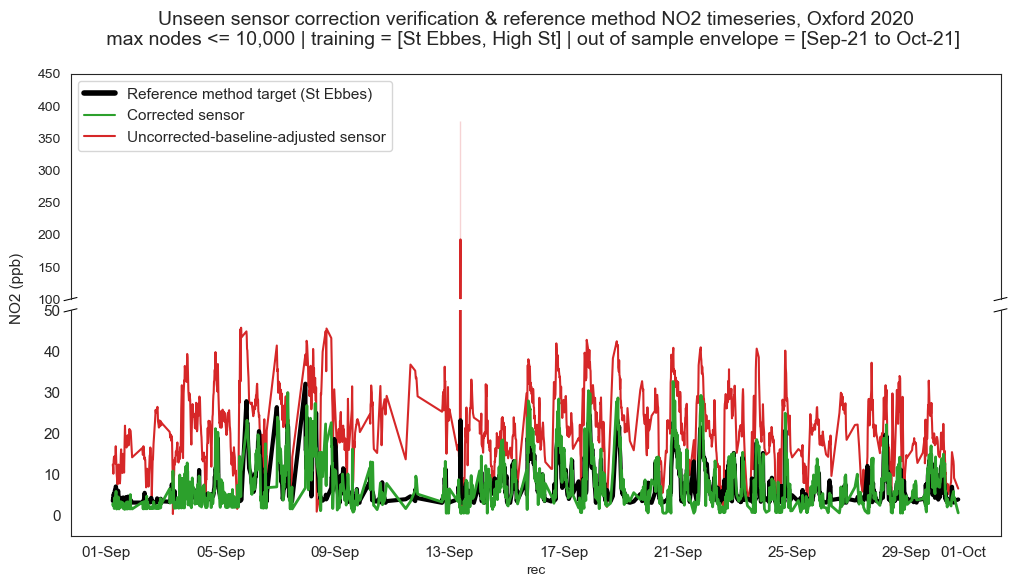

In [23]:
# Plotting the fullstudy results using December 2020 data - split
# ----------------------------------------------------------------

# Generate out of sample / unseen verification set
verification_df = get_training_no2(
    [sebbes_train_s15_1, highs_train_s15_1], "2021-09-01", "2021-10-01"
)
verification_df = verification_df.sort_index()

val_y = verification_df.loc[:, "no2_ppb_combo"]
val_X = verification_df.drop(
    columns=["no2_ppb_s", "no2_ppb_h", "no2_ppb_combo"]
)

norm = Normalizer()
val_X_norm = pd.DataFrame(norm.fit_transform(val_X))
val_X_norm.columns = val_X.columns
val_X_norm.index = val_X.index

# Model prediction
model_prediction = (model.predict(val_X_norm) - 3.151) / 0.762
val_X_2 = pd.concat(
    [
        val_X.reset_index(),
        pd.DataFrame(
            model_prediction, columns=["val.no2.cnc_1_lgbm_norm_cor"]
        ),
    ],
    axis=1,
    ignore_index=True,
)
val_X_2.columns = list(val_X.reset_index().columns) + [
    "val.no2.cnc_1_lgbm_norm_cor"
]
val_X_2 = val_X_2.merge(gases[["no2_ppb_s_bl"]], left_on=['tag','rec'], right_on=['tag','rec'], how='left')
val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
     val_X_2["val.no2.cnc_1_lgbm_norm_cor"] < val_X_2["no2_ppb_s_bl"],
     val_X_2["no2_ppb_s_bl"],
     val_X_2["val.no2.cnc_1_lgbm_norm_cor"],
)

# Set corrected obs to nominal low conc where its still low
#-----------------------------------------------------------
val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
    val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] < 0.5,
    0.5,
    val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"],
)
val_X_2.set_index(['tag','rec'], inplace=True)

# Plotting the verification results using December 2020 data - split
# -------------------------------------------------------------------
sns.set_style('white', {'axes.grid': False})
myFmt = mdates.DateFormatter('%d-%b')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(
    x=val_y.index.get_level_values(1),
    y=val_y.values,
    label='Reference method target (St Ebbes)',
    color='k',
    lw=4,
    zorder=2,
    ax=ax,
)

sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    label='Corrected sensor',
    color='tab:green',
    zorder=3,
    ax=ax,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.no2.cnc_1_c1'],
    label='Uncorrected-baseline-adjusted sensor',
    color='tab:red',
    zorder=1,
    ax=ax,
)
sns.lineplot(
    x=val_y.index.get_level_values(1), 
    y=val_y.values, 
    color='k', 
    lw=3, 
    zorder=4, 
    ax=ax2
)
sns.lineplot(
    x=val_X_2.index.get_level_values(1),
    y=val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    color='tab:green',
    lw=2,
    zorder=5,
    ax=ax2,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.no2.cnc_1_c1'],
    color='tab:red',
    zorder=2,
    ax=ax2,
)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 450)  # outliers only
ax2.set_ylim(-5, 50)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = 0.007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('NO2 (ppb)', fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_title(
    'Unseen sensor correction verification & reference method NO2 timeseries, Oxford 2020\n \
max nodes <= 10,000 | training = [St Ebbes, High St] | out of sample envelope = [Sep-21 to Oct-21]  \n',
    fontsize=14,
)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig(pngs + 'verification_results_pm10_mln6000_e100_536_sebbes_highs_ratified_dec_split.png', dpi=300)
plt.show()


## Export data for CEN uncertainty calculations

In [24]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
# ----------------------------------------------------------------------------
outfile = list(
    zip(
        val_X.index.get_level_values(0),
        val_X.index.get_level_values(1),
        val_y.values,
        model_prediction,
    )
)

with open(
    "values_for_cen_calc_LGBM_model_no2_jun_aug_val_c2_SH_xt_unseen_14jun.csv", "w"
) as out:
    csv_out = csv.writer(out)
    csv_out.writerow(["tag", "rec", "no2_ppb_combo", "val.no2.cnc_1_c2_SH_xt"])
    csv_out.writerows(outfile)

mae_veri = mean_absolute_error(val_y.values, model_prediction)
mae_orig = mean_absolute_error(val_y.values, val_X["val.no2.cnc_1_c1"])

print("MAE in uncorrected verifiction data for Oct: " + str(mae_orig))
print("MAE in corrected verifiction data for Oct: " + str(mae_veri))
print("% 0.1f" % mae_orig, "% 0.1f" % mae_veri)



MAE in uncorrected verifiction data for Oct: 14.814393
MAE in corrected verifiction data for Oct: 2.513590015237339
 14.8  2.5


## Time series showing model performance across the full study period

Getting training features for sensors between: 2020-06-01 00:00:00+00:00 and 2021-10-01 00:00:00+00:00

Sensors in output :['scs-bgx-536', 'scs-bgx-538']



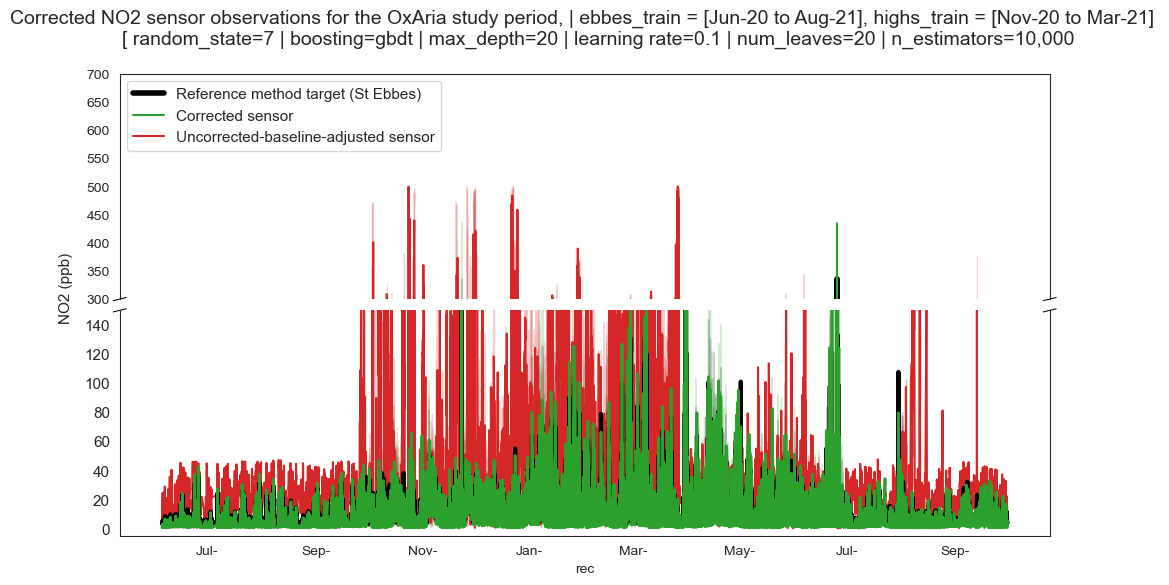

In [26]:
# Plotting the fullstudy results using December 2020 data - split
# --------------------------------------------------------------------

# Generate out of sample / unseen verification set
study_period_df = get_training_no2(
    [sebbes_train_s15_1, highs_train_s15_1], "2020-06-01", "2021-10-01"
)

study_period_df = study_period_df.sort_index()
val_y = study_period_df.loc[:, "no2_ppb_combo"]
val_X = study_period_df.drop(
    columns=["no2_ppb_s", "no2_ppb_h", "no2_ppb_combo"]
)

norm = Normalizer()
val_X_norm = pd.DataFrame(norm.fit_transform(val_X))
val_X_norm.columns = val_X.columns
val_X_norm.index = val_X.index

# Model prediction
model_prediction = (model.predict(val_X_norm) - 3.151) / 0.762
val_X_2 = pd.concat(
    [
        val_X.reset_index(),
        pd.DataFrame(
            model_prediction, columns=["val.no2.cnc_1_lgbm_norm_cor"]
        ),
    ],
    axis=1,
    ignore_index=True,
)
val_X_2.columns = list(val_X.reset_index().columns) + [
    "val.no2.cnc_1_lgbm_norm_cor"
]
val_X_2 = val_X_2.merge(gases[["no2_ppb_s_bl"]], left_on=['tag','rec'], right_on=['tag','rec'], how='left')
val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
     val_X_2["val.no2.cnc_1_lgbm_norm_cor"] < val_X_2["no2_ppb_s_bl"],
     val_X_2["no2_ppb_s_bl"],
     val_X_2["val.no2.cnc_1_lgbm_norm_cor"],
)

# Set corrected obs to nominal low conc where its still low
#-----------------------------------------------------------
val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] = np.where(
    val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"] < 0.5,
    0.5,
    val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"],
)
val_X_2.set_index(['tag','rec'], inplace=True)

sns.set_style("white", {"axes.grid": False})
myFmt = mdates.DateFormatter("%b-")

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(
    x=val_y.index.get_level_values(1),
    y=val_y.values,
    label='Reference method target (St Ebbes)',
    color='k',
    lw=4,
    zorder=2,
    ax=ax,
)

sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    label='Corrected sensor',
    color='tab:green',
    zorder=3,
    ax=ax,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.no2.cnc_1_c1'],
    label='Uncorrected-baseline-adjusted sensor',
    color='tab:red',
    zorder=1,
    ax=ax,
)
sns.lineplot(
    x=val_y.index.get_level_values(1), 
    y=val_y.values, 
    color='k', 
    lw=3, 
    zorder=4, 
    ax=ax2
)
sns.lineplot(
    x=val_X_2.index.get_level_values(1),
    y=val_X_2["val.no2.cnc_1_lgbm_norm_cor_blc"].values,
    color='tab:green',
    lw=2,
    zorder=5,
    ax=ax2,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.no2.cnc_1_c1'],
    color='tab:red',
    zorder=2,
    ax=ax2,
)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 450)  # outliers only
ax2.set_ylim(-5, 50)  # most of the data


# zoom-in / limit the view to different portions of the data
ax.set_ylim(300, 700)  # outliers only
ax2.set_ylim(-5, 150)  # most of the data

# hide the spines between ax and ax2
ax.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position("none")
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = 0.007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color="k", clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel("NO2 (ppb)", fontsize=11)
ax.legend(loc="upper left", fontsize=11)
ax.set_title(
    "Corrected NO2 sensor observations for the OxAria study period, | ebbes_train = [Jun-20 to Aug-21], highs_train = [Nov-20 to Mar-21] \n \
    [ random_state=7 | boosting=gbdt | max_depth=20 | learning rate=0.1 | num_leaves=20 | n_estimators=10,000\n",
    fontsize=14,
)
plt.yticks(fontsize=11)
# plt.savefig(pngs + 'verification_results_pm10_mln6000_e100_536_sebbes_highs_ratified_dec_split.png', dpi=300)
plt.show()


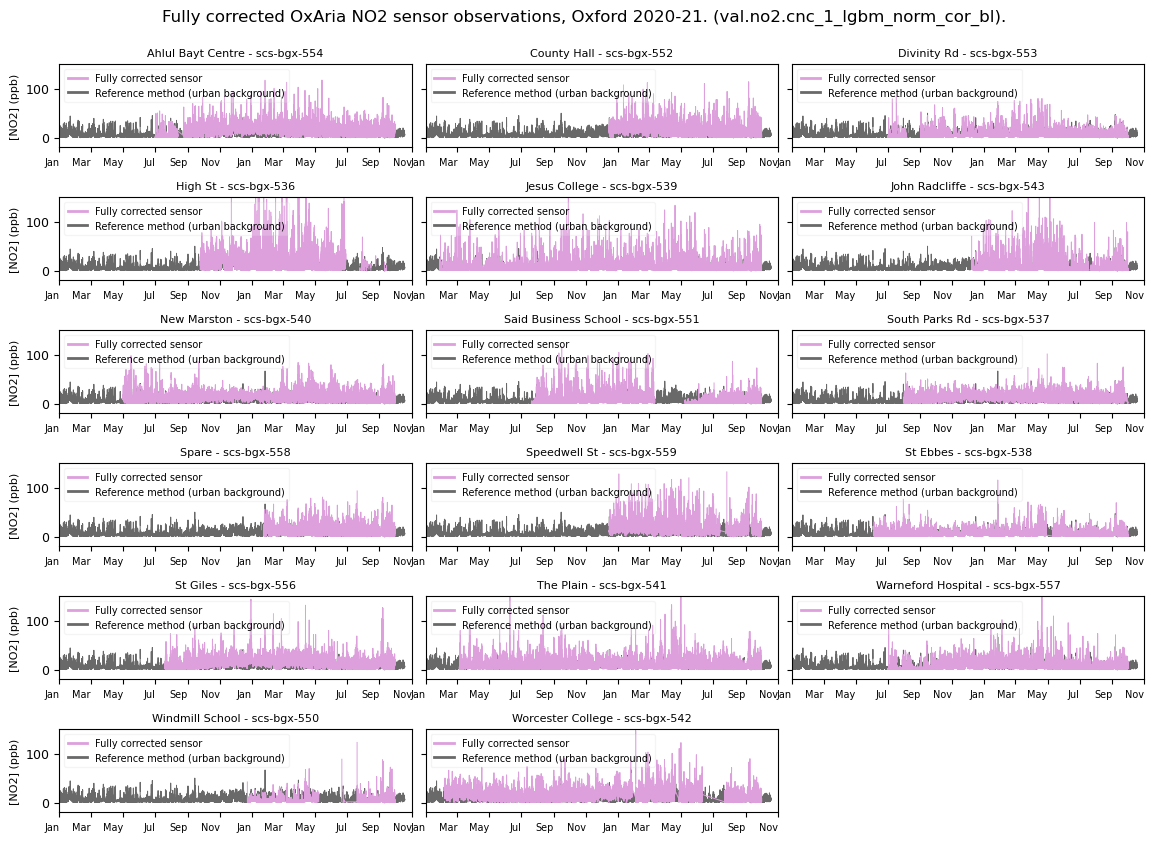

In [27]:
# Plot 15-min pm10
# -----------------
# x_ticks = pd.date_range('2020-01-01', periods=21, freq='MS')
# x_labels = [
#     'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
#     'A', 'M', 'J', 'J', 'A', 'S'
# ]

plt.style.use('default')
myFmt = mdates.DateFormatter('%b')
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2021, 11, 1)

fig, axes = plt.subplots(nrows=6, ncols=3, sharex=False,
                         sharey=True, figsize=(14, 11))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fully corrected OxAria NO2 sensor observations, Oxford 2020-21. (val.no2.cnc_1_lgbm_norm_cor_bl).\n', y=0.93)
for idx, dat in gases.groupby('name'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    t_tag = dat['tag'].unique()
    title_txt = str(t_name[0]) + ' - ' + str(t_tag[0])
    dat.plot(x='rec', y='val.no2.cnc_1_lgbm_norm_cor_blc', c='plum', lw=0.7, marker='', ms=1, ls='-',
             label='Fully corrected sensor', ax=ax, legend=True, zorder=2, x_compat=True)
    auto_merged.reset_index().query('sitecode_s == "OX8"').plot(x='rec', y='no2_ppb_s', c='dimgrey', lw=0.7, marker='',
                                                                ms=0.1, ls='-',
                                                                label='Reference method (urban background)', ax=ax,
                                                                legend=True, zorder=1)
    ax.set_title(title_txt, fontsize=8)
    #ax.set_xticks(x_ticks)
    #ax.set_xticklabels(x_labels)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=7
    )
    ax.xaxis.set_major_formatter(myFmt)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(-20, 150)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')

    plt.subplots_adjust(wspace=0.04, hspace=0.6)

    leg = ax.legend(frameon=True, framealpha=0.2,
                    loc='upper left', ncol=1, fontsize=7)

    for line in leg.get_lines():
        line.set_linewidth(2.0)

fig.delaxes(axes_list[-1])

# plt.savefig(pngs+'oxaria0_pm10_15m_fullycorrected_sensor_ts202021.png')
plt.show()

# for ax in axes_list:
#     ax.remove()


In [28]:
# Save to an ftr file 
#---------------------
gases['val.no2.cnc_1_lgbm_norm_cor_blc_ug'] = gases['val.no2.cnc_1_lgbm_norm_cor_blc'] * 1.9125
gases.reset_index().to_feather(data_home+'jun_to_sept_2021/oxaria_gases_536_stable15_rat_full_norm_corr_blc_202021.ftr')
gases = pd.read_feather(data_home+'jun_to_sept_2021/oxaria_gases_536_stable15_rat_full_norm_corr_blc_202021.ftr').set_index(['tag','name','rec'])
gases.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 655655 entries, ('scs-bgx-536', 'High St', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', 'Speedwell St', Timestamp('2021-10-01 00:00:00+0000', tz='UTC'))
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   val.no2.wev                         655655 non-null  float32
 1   val.no2.cnc                         654151 non-null  float32
 2   val.no2.aev                         655655 non-null  float32
 3   val.no2.wec                         654151 non-null  float32
 4   val.sht.hmd_g                       654151 non-null  float32
 5   val.sht.tmp_g                       654151 non-null  float32
 6   val.no2.cnc_1                       641891 non-null  float32
 7   mag_hmd_s20                         654149 non-null  float32
 8   mag_tmp_s20                         654149 non-null  float32
 9   mean_hmd_s

In [ ]:
# # Clean & tidy it to crteated a file for public dissemination
# #-------------------------------------------------------------
# gases0 = gases.iloc[:,[0,2,3,4,5,22]]
# gases0 = gases0.rename(columns={'val.sht.hmd_g':'val.sht.hmd','val.sht.tmp_g':'val.sht.tmp', 'val.no2.cnc_1_lgbm_norm_cor_blc':'no2_fcor_ppb'})
# gases0['creation_date'] = dt.datetime.now(dt.timezone.utc)
# gases0.reset_index().to_feather(data_home+'jun_to_sept_2021/oxaria_no2_app_data_corr_blc_202021.ftr')
# gases0.info()